# Critical Exploration of Transformer Models

In this tutorial, we're not just using transformers; we're delving into their inner workings to understand and influence their behavior. We will aim to think critically about transformers beyond their immediate utility in tasks like classification or translation. 

### What We'll Explore:

1. **Adversarial Inputs**: Learn to craft inputs that challenge and probe the limits of language models.
2. **Attention Visualization**: Gain insights into how transformers focus on different parts of the input and output.
3. **Fine-Tuning with LoRA**: Understand how to implement Low-Rank Adaptation (LoRA) for model finetuning.
4. **Bias Detection**: Investigate inherent biases in model responses.

**Practical:**: We've compiled all classes from our practical sessions into `utils.py` and `models.py`, with minor adjustments for detailed analyses like extracting attention scores. We'll use a model trained in the 'Attention is All You Need' practical session, so ensure your initializing parameters are present in `models` directly.

**Note:** This session is designed to be lightweiggt. We'll explore a few key methods to probe and augment transformers without delving into complex research papers or methodologies. Consider this a starting point - the potential applications and explorations in this field are vast. Should any topic pique your interest or seem pertinent to your work, don't hesitate to reach out to your tutor for more in-depth resources and references.

In [19]:
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
from utils import *
from models import *
print(device)

cuda


In [3]:
# model directory to load the best model
model_dir = pathlib.Path("./models").resolve()

# load the best model
N_ENCODERS = 3
N_DECODERS = 3
EMB_SIZE = 128
N_HEADS = 8
FFN_HID_DIM = 256
model = Transformer(SRC_N_TOKENS, TGT_N_TOKENS, N_ENCODERS, N_DECODERS, EMB_SIZE, N_HEADS, FFN_HID_DIM)
model.load_state_dict(torch.load(model_dir / "best.ckpt"))
model = model.to(device) 

loss_fn = LabelSmoothingLoss(TGT_N_TOKENS, 0.1)

## Crafting Adversarial Inputs for Transformers

Adversarial inputs are crucial for testing and improving the robustness of transformer models. In this tutorial, we'll explore two primary methods to generate these inputs:

#### 1. **Gradient Propagation**

We'll employ the Fast Gradient Sign Method (FGSM) (Goodfellow et al. 2014) to create adversarial inputs.
 - Compute the loss function for a specific input.
 - Calculate the gradient of this loss.
 - Apply the negative of this gradient to perturb the input subtly.

The perturbed inputs, while slightly altered, shouldn't change the target, yet they result in increased loss.

**Note**: This method works at the embeddings level, not directly with word-level inputs.

#### 2. **Manual Crafting Using Synonyms**

We manually craft inputs by substituting words with their synonyms. The output should remain unchanged with these substitutions. Any input that causes a change in output under this substitution is considered an adversarial input.

Through these techniques, we'll gain a deeper understanding of the vulnerabilities and resilience of transformer models, aiding in their development and refinement.

[[Goodfellow et al. 2014](!https://arxiv.org/abs/1412.6572)] Explaining and Harnessing Adversarial Examples.

#### Gradient Propagation

In [9]:
src, tgt = get_sample_batch('train', 1)

# Copy-pasted from `process` 
src = src.to(device)
tgt = tgt.to(device)

# ignore last token in the tgt because at the time of predicting the last token, available inputs will be everything before that token
tgt_input = tgt[:, :-1]

# create masks
src_padding_mask, tgt_mask = create_masks(src, tgt_input)
src_padding_mask = src_padding_mask.to(device)
tgt_mask = tgt_mask.to(device)

# Creating input embeddings from the source and detaching to avoid tracking history
input_embeddings = model.src_embeddings(src).detach()
# Enabling gradient calculation for the input embeddings
input_embeddings.requires_grad = True

logits, attn_scores = model(src, tgt_input, src_padding_mask, tgt_mask, input_embeddings)

# target predictions are made for 1st token onwards. 0th token is assumed to be <BOS> by design of the model. Read no-peak masking (above) for more details.
tgt_out = tgt[:, 1:]

# compute loss
loss = loss_fn(logits, tgt_out)
print(f'loss before perturbation: {loss: 0.6f}')

# Resetting gradients to zero before backward pass
model.zero_grad()
loss.backward()

# Retrieving the gradient of the input
### YOUR CODE HERE (extract the gradients of input_embeddings)
# input_gradients = 

# Applying Fast Gradient Sign Method (FGSM) for adversarial training
epsilon = 0.01  # Small magnitude of perturbation

# Creating perturbed embeddings by adding small perturbations to the input embeddings
### YOUR CODE HERE (perturb the inputs by epsilon in the direction of the input_gradients)
# perturbed_embeddings = 

# Forward pass with perturbed embeddings to evaluate model performance on adversarial example
logits, _ = model(src, tgt_input, src_padding_mask, tgt_mask, perturbed_embeddings)
loss_after = loss_fn(logits, tgt_out)
print(f'loss after perturbation: {loss_after: 0.6f}')

percent_increase = 100* (loss_after - loss) / loss
print(f"percent increase in the loss: {percent_increase:0.2f}%")

loss before perturbation:  2.429346
loss after perturbation:  2.502872
percent increase in the loss: 3.03%


#### Manual crafting using synonyms

Manual crafting of inputs to test transformer models can be a time-consuming task. However, with the right techniques, we can automate parts of this process for efficiency. Here's a streamlined approach to get you started:

##### Step 1: Selecting Target Words
- Begin by identifying key words in your sentences that are likely to influence the model's output significantly.

##### Step 2: Automated Synonym Replacement
- Use natural language processing tools (like NLTK) to find synonyms for these selected words.

##### Step 3: Sentence Reconstruction
- Integrate these synonyms back into your sentences, ensuring they fit grammatically and contextually.

##### Step 4: Testing and Iteration
- Feed these modified sentences into your model to observe any changes in output.
- Iterate this process, refining your word selection and replacement strategy for optimal results.

By following these steps, you can make the process of crafting adversarial or test inputs for transformer models more efficient and less labor-intensive.




In [12]:
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char.isalpha()])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def synonym_replacement(sentence, num_replacements=1):
    words = nltk.word_tokenize(sentence)
    new_words = words.copy()
    replaced = 0
    for word in words:
        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = [synonym if w == word else w for w in new_words]
            replaced += 1
            if replaced >= num_replacements:
                break
    return ' '.join(new_words)

# Example
original_sentence = "The quick brown fox jumps over the lazy dog."
adversarial_sentence = synonym_replacement(original_sentence, num_replacements=2)
print("Original:", original_sentence)
print("Adversarial:", adversarial_sentence)


Original: The quick brown fox jumps over the lazy dog.
Adversarial: The immediate brownuniversity fox jumps over the lazy dog .


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mila/g/guptapra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mila/g/guptapra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Visualization of attention 

Visualizing attention in a Transformer model can provide significant insights into how the model processes and interprets input data. However, deciding which layer(s) to visualize depends on what you want to understand or demonstrate. The Transformer architecture, as proposed by Vaswani et al., consists of multiple layers of encoders and decoders, each with its multi-head attention mechanism. Here are some considerations for choosing which layer's attention to visualize:

### Encoder Layers:

1. **Early Encoder Layers**: These layers often capture more about the syntax and structure of the input text. Visualizing attention here can show how the model is focusing on different parts of the input sentence to understand its grammatical structure.

2. **Later Encoder Layers**: These tend to capture more abstract and contextual information. Visualizing attention in these layers can reveal how different words or phrases in the input sentence are related in terms of meaning or context.

### Decoder Layers:

1. **Early Decoder Layers**: In the decoder, early layers might focus more on aligning with the relevant parts of the input sequence (in the case of tasks like translation). This is where the cross-attention mechanism plays a key role, and visualizing it can show how each word in the output sequence is being aligned with words in the input sequence.

2. **Later Decoder Layers**: These layers are more about refining the output and capturing the broader context of the entire sequence. Attention visualizations here can show how the model consolidates information from the input and the partially decoded sequence to produce the final output.

### Cross-Attention vs. Self-Attention:

- **Cross-Attention (Decoder)**: Specifically in translation tasks, cross-attention layers in the decoder show how each word in the target language is being aligned to words in the source language. This can be crucial for understanding translation decisions made by the model.

- **Self-Attention (Both Encoder and Decoder)**: Self-attention in both the encoder and decoder shows dependencies and relationships within the same sequence (source in encoder, target in decoder). 

### Practical Approach:

A practical approach to attention visualization in Transformers would be to start with one layer (e.g., the first or last layer of the encoder), then compare it with other layers to see how attention patterns evolve. This can provide a comprehensive view of how the model's focus shifts from capturing basic syntactic relationships to understanding complex semantic contexts.

In [24]:
src, tgt = get_sample_batch('train', 1)

# Copy-pasted from `process` 
src = src.to(device)
tgt = tgt.to(device)

# ignore last token in the tgt because at the time of predicting the last token, available inputs will be everything before that token
tgt_input = tgt[:, :-1]

# create masks
src_padding_mask, tgt_mask = create_masks(src, tgt_input)
src_padding_mask = src_padding_mask.to(device)
tgt_mask = tgt_mask.to(device)

logits, attn_scores = model(src, tgt_input, src_padding_mask, tgt_mask)

print(f"Following keys are in attn_scores: {attn_scores.keys()}")

Following keys are in attn_scores: dict_keys(['encoder_attn', 'decoder_ss', 'decoder_cs'])


In [20]:
sentence = get_readable_tokens(src[0, :].cpu(), SRC_LANGUAGE)
predicted_sentence = get_readable_tokens(tgt[0, :].cpu(), TGT_LANGUAGE)

## Parameters to define specific attention layer
batch_idx = 0 # which sentence in the batch
layer = 2 # which layer
head_idx = 0 # which head


#### Visualizing cross-attention

Scores shape: (12, 15)


<Axes: >

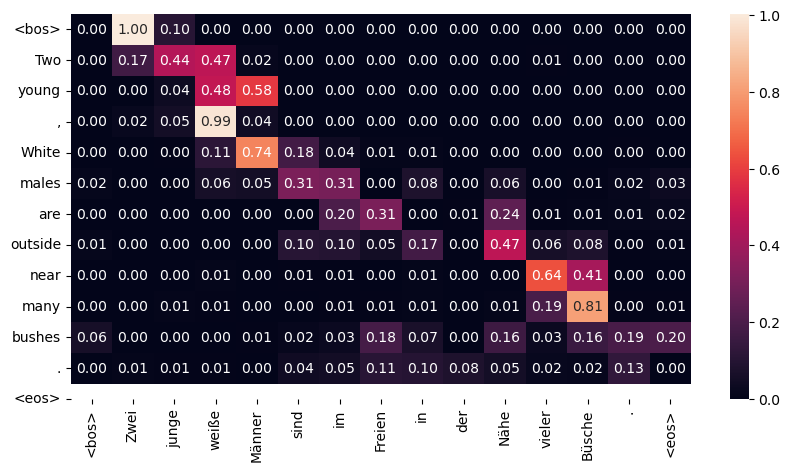

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100)

scores = attn_scores['decoder_cs'][layer].cpu().detach().numpy()
print(f"Attention scores shape: {scores[batch_idx, head_idx].shape}")

sns.heatmap(scores[batch_idx, head_idx], annot=True,
            xticklabels=sentence, yticklabels=predicted_sentence, ax=ax, fmt=".2f")


#### Visualizing self-attention

Scores shape: (12, 12)


<Axes: >

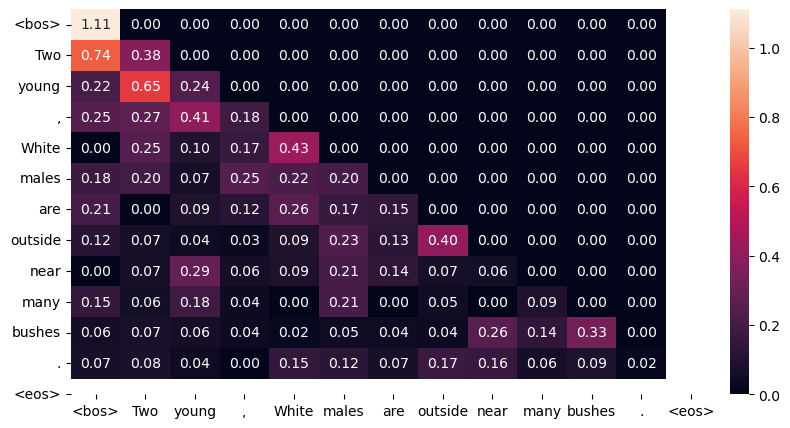

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100)

scores = attn_scores['decoder_ss'][layer].cpu().detach().numpy()

print(f"Scores shape: {scores[batch_idx, head_idx].shape}")
sns.heatmap(scores[batch_idx, head_idx], annot=True,
            xticklabels=predicted_sentence, yticklabels=predicted_sentence, ax=ax, fmt=".2f")


### Implementing Low-Rank Adaptation (LoRA) for LLMs

In this section, we'll implement the Low-Rank Adaptation (LoRA) for Large Language Models (LLMs), as proposed in Hu et al. 2021. LoRA focuses on refining pre-trained transformer models without altering the original model weights.



#### Overview of LoRA
We introduce additional, trainable parameters to the model, which are significantly fewer in number than the original weights. These new parameters are adjusted according to a loss function, using an additional dataset.

Here is the description from the paper 

<img src="img/lora_def.png">

#### Steps for Implementation
1. **Freezing Pre-trained Parameters**: Ensure all original model parameters are fixed and not updated during training.

2. **Calculating Loss with LoRA Weights**:
   - Compute the loss function on a sample batch.
   - Backpropagate this loss specifically to train the LoRA weights.

3. **Iterative Training**:
   - Continuously adjust the LoRA weights based on the loss calculation.
   - Aim for the model to adapt to new data while retaining its original capabilities.


This approach allows for a more efficient and targeted adaptation of LLMs, enhancing their performance on specific tasks or datasets without the need for extensive retraining.


[[Hu et al. 2021](!https://arxiv.org/abs/2106.09685)] LoRA: Low-Rank Adaptation of Large Language Models

##### Approach
Instead of fine-tuning the entire model, we'll apply LoRA only to the encoder's Q and V. Thus, We'll focus on a targeted adaptation of our transformer model's encoders, specifically modifying the Query (Q) and Value (V) matrices, as suggested by Hu et al. in their paper.

In [ ]:
def get_num_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
class LoRA(nn.Module):
    def __init__(self, base_module, rank, d_in, d_out):
        super(LoRA, self).__init__()
        
        self.base_module = base_module
        
        ### YOUR CODE HERE
        # self.A = nn.Parameter(torch.randn(?, ?))
        # self.B = nn.Parameter(torch.randn(?, ?))        
    
    def forward(self, x):
        out = self.base_module(x)
        ### YOUR CODE HERE
        # lora_update = 
        return out + lora_update

Let's **freeze all the parameters** so that they are fixed to their pretrained values.

In [65]:
print(f'Number of trainable parameters: {get_num_trainable_params(model)}')
for name, params in model.named_parameters():
    params.requires_grad = False
    
    if 'mha.Q' in name or 'mha.V' in name:
        print(name)

print(f'Number of trainable parameters: {get_num_trainable_params(model)}')

Number of trainable parameters: 6090070
encoders.0.mha.Q.weight
encoders.0.mha.Q.bias
encoders.0.mha.V.weight
encoders.0.mha.V.bias
encoders.1.mha.Q.weight
encoders.1.mha.Q.bias
encoders.1.mha.V.weight
encoders.1.mha.V.bias
encoders.2.mha.Q.weight
encoders.2.mha.Q.bias
encoders.2.mha.V.weight
encoders.2.mha.V.bias
Number of trainable parameters: 0


Let's make encoders retrainable by subclassing them with LoRA. 

In [67]:
for encoder in model.encoders:
    d_in = encoder.mha.Q.in_features
    d_out = encoder.mha.Q.out_features
    
    ### YOUR CODE HERE 
    # encoder.mha.Q = 
    
    d_in = encoder.mha.V.in_features
    d_out = encoder.mha.V.out_features  
    
    ### YOUR CODE HERE
    # encoder.mha.V = 
    
print(f'Number of trainable parameters: {get_num_trainable_params(model)}')

Number of trainable parameters: 6144


Now, we will compute the loss function on a sample batch and backpropagate the loss to train LoRA weights

In [68]:
# finetune these parameters
loss = LabelSmoothingLoss(TGT_N_TOKENS, 0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

src, tgt = get_sample_batch('train', 10)

# Copy-pasted from `process` 
src = src.to(device)
tgt = tgt.to(device)

# ignore last token in the tgt because at the time of predicting the last token, available inputs will be everything before that token
tgt_input = tgt[:, :-1]

# create masks
src_padding_mask, tgt_mask = create_masks(src, tgt_input)
src_padding_mask = src_padding_mask.to(device)
tgt_mask = tgt_mask.to(device)

logits, attn_scores = model(src, tgt_input, src_padding_mask, tgt_mask)

loss = loss_fn(logits, tgt_input)

optimizer.zero_grad()
loss.backward()
optimizer.step()

torch.Size([10, 18, 128]) torch.Size([10, 18, 128])
torch.Size([10, 18, 128]) torch.Size([10, 18, 128])
torch.Size([10, 18, 128]) torch.Size([10, 18, 128])
torch.Size([10, 18, 128]) torch.Size([10, 18, 128])
torch.Size([10, 18, 128]) torch.Size([10, 18, 128])
torch.Size([10, 18, 128]) torch.Size([10, 18, 128])


## Bias checking 

Crafting inputs to check for bias or unethical outputs in a Transformer model requires a careful and systematic approach. Transformers, like any machine learning model, can exhibit biases that are present in their training data. Testing for these biases involves probing the model with inputs designed to reveal discriminatory, unfair, or otherwise unethical responses. 


1. **Identify Potential Areas of Bias:** Start by identifying dimensions along which biases might occur. Common areas include gender, race, ethnicity, age, sexual orientation, religion, and political viewpoint. Bias can manifest in various forms, including stereotyping, underrepresentation, or overrepresentation of certain groups.


2. **Design Test Cases:** Create a set of inputs that specifically target these potential areas of bias. The test cases should be designed to reveal any preferential treatment, stereotyping, or derogatory outputs related to the identified dimensions. Examples include:
    - ***Gender Bias***: Inputs comparing professions or activities with different gender pronouns (e.g., "He is a nurse" vs. "She is a nurse").
    - ***Racial or Ethnic Bias***: Sentences describing people of different races or ethnicities in various contexts, checking for differences in sentiment or tone.
    - ***Religious or Political Bias***: Statements about different religious or political groups to see if the model responds more favorably or unfavorably to some.


3. **Neutral and Comparative Inputs:** For each test case, it's helpful to have a neutral input for comparison. This neutral input should be as similar as possible to the test case but without the specific bias-inducing element.


4. **Evaluate the Outputs:** Run these test cases through your Transformer model and evaluate the outputs. Look for:
    - ***Differences in Sentiment or Tone***: Is the language noticeably more positive or negative for certain groups?
    - ***Use of Stereotypes***: Does the model rely on stereotypes or generalizations?
    - ***Differential Treatment***: Are similar actions or qualities described differently based on the group being referred to?


5. **Quantitative Analysis:** Where possible, perform a quantitative analysis. For instance, use sentiment analysis tools to get objective measures of the tone of the outputs, or employ statistical tests to see if differences in treatment are significant.

6. **Iterative Testing:** Bias testing should be iterative. Based on findings, refine your test cases and probe deeper into areas where biases were uncovered.

### Example Test Case for Gender Bias:

Let's consider an example for testing gender bias:

- **Test Input**: "The doctor asked the nurse for assistance in the operation."
- **Neutral Comparative Input**: "The doctor asked the colleague for assistance in the operation."
- **Biased Variant**: Switch gender pronouns or names traditionally associated with different genders, e.g., "The doctor asked him for assistance" vs. "The doctor asked her for assistance."

**Ethical Considerations:** While testing for bias, it's crucial to handle sensitive topics with care and respect. The goal is to make AI more fair and equitable, not to perpetuate stereotypes or harm.

Bias testing in Transformer models is an evolving area. Continuous monitoring and testing, coupled with a commitment to ethical AI practices, are necessary to mitigate biases. 

In [12]:
gender_neutral_pairs = [
    ("Die Krankenschwester verabreichte Medizin.", "The nurse administered medicine."),
    ("Der Ingenieur reparierte das Auto.", "The engineer fixed the car."),
    ("Ein Koch bereitete das Essen zu.", "A chef cooked the meal."),
    ("Der Lehrer erklärte die Lektion.", "The teacher explained the lesson."),
    ("Der Pilot flog das Flugzeug.", "The pilot flew the plane."),
    ("Die Sekretärin organisierte die Akten.", "The secretary organized the files."),
    ("Der Programmierer schrieb den Code.", "The programmer wrote the code."),
    ("Der Wissenschaftler veröffentlichte eine Abhandlung.", "The scientist published a paper."),
    ("Der Fahrer gewann das Rennen.", "The driver won the race."),
    ("Der Manager leitete das Treffen.", "The manager led the meeting.")
]

# If the model is biased, it will produce a translation which is biased towards a specific group. 

In [13]:
src, tgt = collate_fn(gender_neutral_pairs)
output = greedy_decoding(model, src, 10)
output_sentence = [get_readable_text(get_readable_tokens(output[i, :].cpu(), TGT_LANGUAGE)) for i in range(src.shape[0])]

for i in range(src.shape[0]):
    print("\n")
    print(f'Translated sentence: {output_sentence[i]}')
    print(f'Expected sentence: {gender_neutral_pairs[i][1]}')



Translated sentence:  The nurse is receiving fencing .    
Expected sentence: The nurse administered medicine.


Translated sentence:  The professional athlete is kicking the car .  
Expected sentence: The engineer fixed the car.


Translated sentence:  A chef is preparing food .    
Expected sentence: A chef cooked the meal.


Translated sentence:  The teacher is scooping up the backstroke .  
Expected sentence: The teacher explained the lesson.


Translated sentence:  The pilot is sweeping the plane .   
Expected sentence: The pilot flew the plane.


Translated sentence:  The senior citizens is scooping up the sprinkler . 
Expected sentence: The secretary organized the files.


Translated sentence:  The professional athlete is crouched in the marble . 
Expected sentence: The programmer wrote the code.


Translated sentence:  The scientist is wearing a professional uniform is doing a
Expected sentence: The scientist published a paper.


Translated sentence:  The driver is racing in 